In [1]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.decomposition import PCA

# -------------------------------
# 1. Filtering
# -------------------------------
def butter_lowpass_filter(data, cutoff=5, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

def high_pass_filter(data, cutoff=0.1, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high')
    return filtfilt(b, a, data)

def filter_signal(signal, fs=100):
    return high_pass_filter(butter_lowpass_filter(signal, fs=fs), fs=fs)

# -------------------------------
# 2. PCA + Projection
# -------------------------------
def identify_joint_axis(gyro_data):
    pca = PCA(n_components=1)
    pca.fit(gyro_data)
    return pca.components_[0]

def project_onto_joint_axis(gyro_data, joint_axis):
    return np.dot(gyro_data, joint_axis)

# -------------------------------
# 3. Integrate Gyro to Angle
# -------------------------------
def integrate_gyro(gyro_data, time, initial_angle=0):
    angle = np.cumsum(gyro_data * np.gradient(time))
    return angle - np.mean(angle[:50]) + initial_angle

# -------------------------------
# 4. Detect Gait Phases
# -------------------------------
def label_gait_phases(force, knee_angle, time, hs_thresh=1500, to_thresh=300, flex_thresh=30):
    """
    Labels each timestep of the gait cycle with one of:
    'Heel Strike', 'Stance', 'Toe-Off', 'Swing'

    Parameters:
        force       : list or array of force sensor values
        knee_angle  : list or array of knee joint angles
        time        : list or array of timestamps
        hs_thresh   : threshold to detect Heel Strike
        to_thresh   : threshold to detect Toe-Off (low force)
        flex_thresh : knee flexion threshold to assume swing

    Returns:
        labels      : list of gait phase labels
        heel_strikes: list of timestamps of detected Heel Strikes
        toe_offs    : list of timestamps of detected Toe-Offs
    """
    labels = []
    heel_strikes = []
    toe_offs = []
    stance = False  # whether the foot is currently in stance

    for i in range(1, len(force)):
        if not stance:
            # Detect Heel Strike
            if force[i] > hs_thresh:
                stance = True
                heel_strikes.append(time[i])
                labels.append("Heel Strike")
            # Otherwise, Swing phase (flexed knee or foot off ground)
            else:
                labels.append("Swing")
        else:
            # Detect Toe-Off
            if force[i] < to_thresh:
                stance = False
                toe_offs.append(time[i])
                labels.append("Toe-Off")
            else:
                labels.append("Stance")

    # First sample handling
    labels = [labels[0]] + labels  # padding to keep same length
    return labels[:len(force)], heel_strikes, toe_offs



# -------------------------------
# 5. Example Usage
# -------------------------------
# Load your merged data
data = pd.read_csv("combined_dataset.csv")  # Replace with actual file

# Filter IMU gyros
fs = 100  # sampling rate
for col in ["LS_GyroX", "LS_GyroY", "LS_GyroZ", "LT_GyroX", "LT_GyroY", "LT_GyroZ", "LA_GyroX", "LA_GyroY", "LA_GyroZ", "RS_GyroX", "RS_GyroY", "RS_GyroZ", "RT_GyroX", "RT_GyroY", "RT_GyroZ", "RA_GyroX", "RA_GyroY", "RA_GyroZ"]:
    data[col + "_filtered"] = filter_signal(data[col], fs)

# Extract gyro data
left_shank_gyro = data[["LS_GyroX_filtered", "LS_GyroY_filtered", "LS_GyroZ_filtered"]].to_numpy()
left_thigh_gyro = data[["LT_GyroX_filtered", "LT_GyroY_filtered", "LT_GyroZ_filtered"]].to_numpy()

# Match length
min_len = min(len(left_shank_gyro), len(left_thigh_gyro))
left_shank_gyro = left_shank_gyro[:min_len]
left_thigh_gyro = left_thigh_gyro[:min_len]
time = data["Time"].to_numpy()[:min_len] / 1000  # Time in seconds
left_force = data["Left_Force"].to_numpy()[:min_len]

# PCA projection and knee angle
left_knee_axis = identify_joint_axis(left_shank_gyro - left_thigh_gyro)
shank_proj = project_onto_joint_axis(left_shank_gyro, left_knee_axis)
thigh_proj = project_onto_joint_axis(left_thigh_gyro, left_knee_axis)
left_knee_angle = integrate_gyro(shank_proj - thigh_proj, time)

# Label gait phases
labels, heel_strikes, toe_offs = label_gait_phases(left_force, left_knee_angle, time)

# Save labels back
data = data.iloc[:min_len]
data["Left_Knee_Angle"] = left_knee_angle
data["Gait_Phase"] = labels

# Optional: Save to file
data.to_csv("labeled_gait_data.csv", index=False)




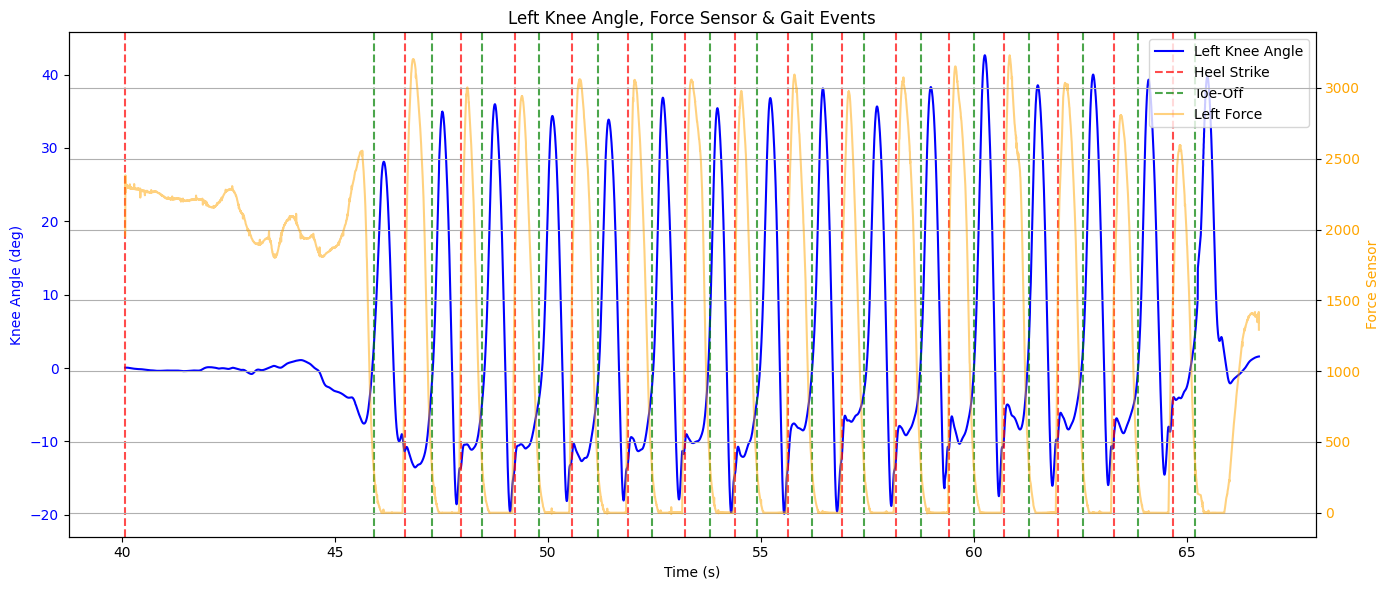

In [2]:
import matplotlib.pyplot as plt

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Left Knee Angle
ax1.plot(time, left_knee_angle, label="Left Knee Angle", color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Knee Angle (deg)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Mark Heel Strikes
for hs in heel_strikes:
    ax1.axvline(hs, color='red', linestyle='--', alpha=0.7, label='Heel Strike' if hs == heel_strikes[0] else "")

# Mark Toe-Offs
for to in toe_offs:
    ax1.axvline(to, color='green', linestyle='--', alpha=0.7, label='Toe-Off' if to == toe_offs[0] else "")

# Plot Left Force on second axis
ax2 = ax1.twinx()
ax2.plot(time, left_force, label="Left Force", color='orange', alpha=0.5)
ax2.set_ylabel("Force Sensor", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.title("Left Knee Angle, Force Sensor & Gait Events")
plt.grid()
plt.tight_layout()
plt.show()


In [3]:
# Extract gyro for ankle and shank
left_ankle_gyro = data[["LA_GyroX_filtered", "LA_GyroY_filtered", "LA_GyroZ_filtered"]].to_numpy()
left_shank_gyro = data[["LS_GyroX_filtered", "LS_GyroY_filtered", "LS_GyroZ_filtered"]].to_numpy()

# Match lengths
min_len = min(len(left_ankle_gyro), len(left_shank_gyro))
left_ankle_gyro = left_ankle_gyro[:min_len]
left_shank_gyro = left_shank_gyro[:min_len]
time = data["Time"].to_numpy()[:min_len] / 1000

# PCA on relative ankle-shank motion
left_ankle_axis = identify_joint_axis(left_ankle_gyro - left_shank_gyro)
ankle_proj = project_onto_joint_axis(left_ankle_gyro, left_ankle_axis)
shank_proj = project_onto_joint_axis(left_shank_gyro, left_ankle_axis)

# Compute ankle angle
left_ankle_angle = integrate_gyro(ankle_proj - shank_proj, time)


In [4]:
labels_ankle, heel_strikes_ankle, toe_offs_ankle = label_gait_phases(left_force, left_ankle_angle, time)

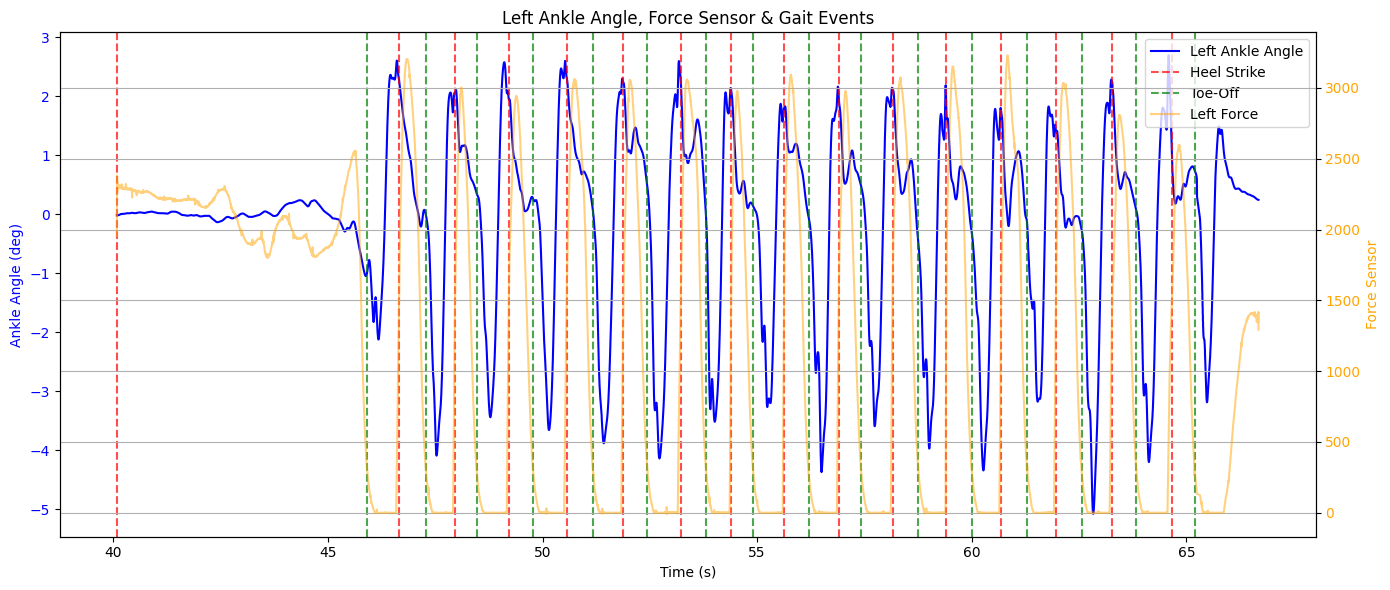

In [5]:
import matplotlib.pyplot as plt

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Left Knee Angle
ax1.plot(time, left_ankle_angle, label="Left Ankle Angle", color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ankle Angle (deg)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Mark Heel Strikes
for hs in heel_strikes_ankle:
    ax1.axvline(hs, color='red', linestyle='--', alpha=0.7, label='Heel Strike' if hs == heel_strikes_ankle[0] else "")

# Mark Toe-Offs
for to in toe_offs_ankle:
    ax1.axvline(to, color='green', linestyle='--', alpha=0.7, label='Toe-Off' if to == toe_offs_ankle[0] else "")

# Plot Left Force on second axis
ax2 = ax1.twinx()
ax2.plot(time, left_force, label="Left Force", color='orange', alpha=0.5)
ax2.set_ylabel("Force Sensor", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.title("Left Ankle Angle, Force Sensor & Gait Events")
plt.grid()
plt.tight_layout()
plt.show()


In [6]:
# --- RIGHT LEG ANGLE CALCULATION ---
right_ankle_gyro = data[["RA_GyroX_filtered", "RA_GyroY_filtered", "RA_GyroZ_filtered"]].to_numpy()
right_shank_gyro = data[["RS_GyroX_filtered", "RS_GyroY_filtered", "RS_GyroZ_filtered"]].to_numpy()

min_len = min(len(right_ankle_gyro), len(right_shank_gyro))
right_ankle_gyro = right_ankle_gyro[:min_len]
right_shank_gyro = right_shank_gyro[:min_len]
time_r = data["Time"].to_numpy()[:min_len] / 1000
right_force = data["Right_Force"].to_numpy()[:min_len]

# PCA + Projection
right_axis = identify_joint_axis(right_ankle_gyro - right_shank_gyro)
ra_proj = project_onto_joint_axis(right_ankle_gyro, right_axis)
rs_proj = project_onto_joint_axis(right_shank_gyro, right_axis)

# Angle Integration
right_ankle_angle = integrate_gyro(ra_proj - rs_proj, time_r)

# Label Phases
right_labels, right_heel_strikes, right_toe_offs = label_gait_phases(
    right_force, right_ankle_angle, time_r
)

# Save to DataFrame
data["Right_Ankle_Angle"] = np.nan
data["Right_Gait_Phase"] = np.nan
data.loc[:min_len, "Right_Ankle_Angle"] = right_ankle_angle
data.loc[:min_len, "Right_Gait_Phase"] = right_labels


/var/folders/2d/fcgrngd95_b823fdj1fwwj840000gn/T/ipykernel_6506/1061346372.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing', 'Swing'

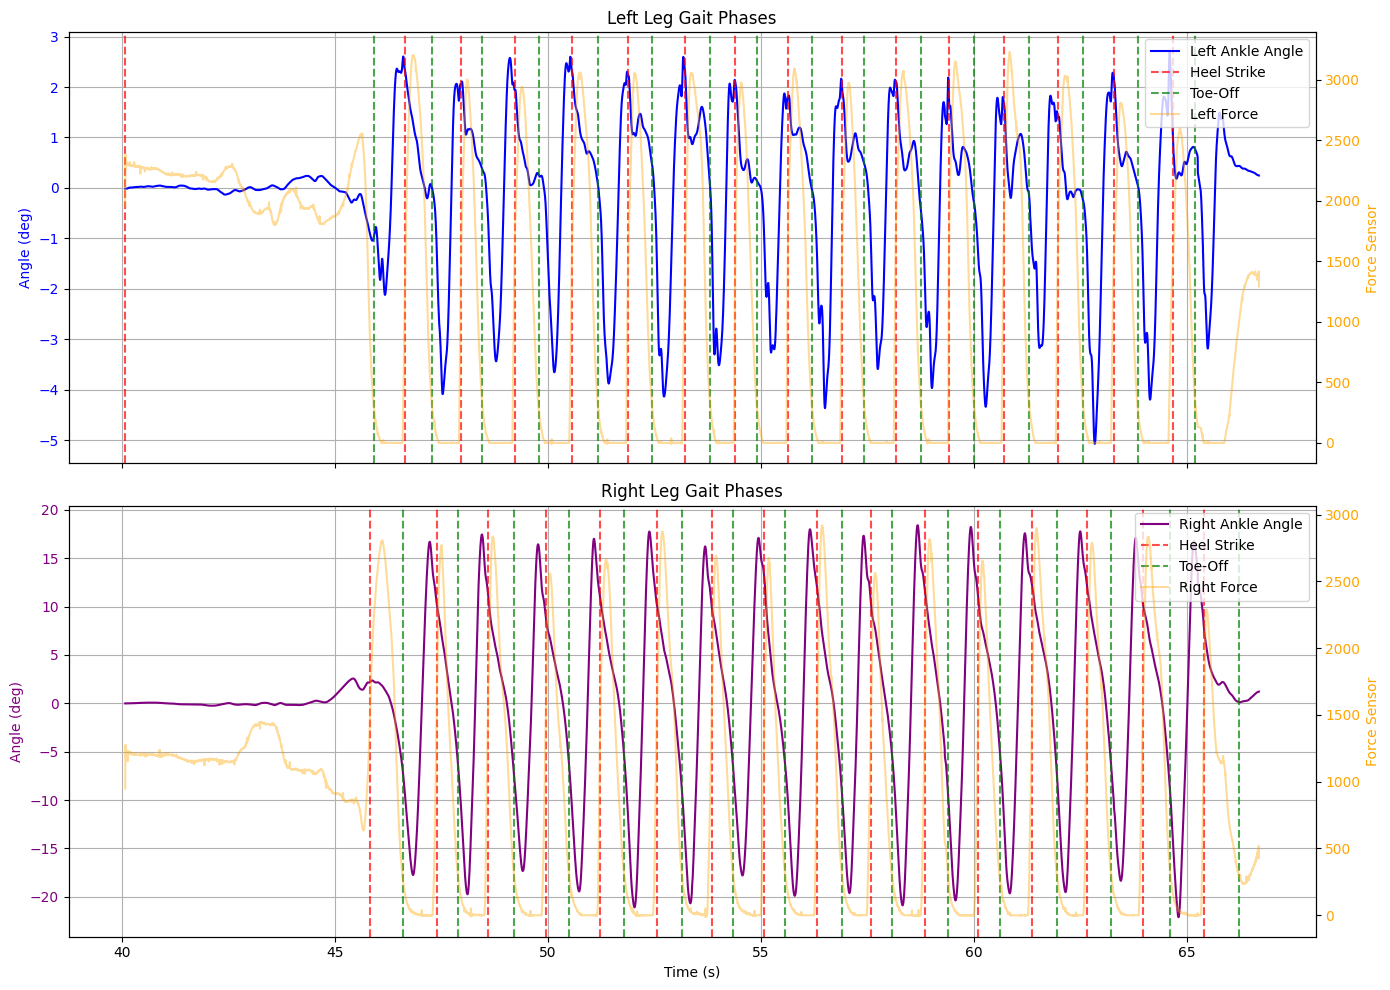

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# === LEFT LEG ===
ax1 = axs[0]
ax2 = ax1.twinx()

# Plot angle on left Y-axis
ax1.plot(time, left_ankle_angle, label="Left Ankle Angle", color='blue')
ax1.set_ylabel("Angle (deg)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Left Leg Gait Phases")

# Plot force on right Y-axis
ax2.plot(time, left_force, label="Left Force", color='orange', alpha=0.4)
ax2.set_ylabel("Force Sensor", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Mark events
for i, hs in enumerate(heel_strikes_ankle):
    ax1.axvline(hs, color='red', linestyle='--', alpha=0.7, label='Heel Strike' if i == 0 else "")
for i, to in enumerate(toe_offs_ankle):
    ax1.axvline(to, color='green', linestyle='--', alpha=0.7, label='Toe-Off' if i == 0 else "")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
ax1.grid()

# === RIGHT LEG ===
ax3 = axs[1]
ax4 = ax3.twinx()

# Plot angle on left Y-axis
ax3.plot(time_r, right_ankle_angle, label="Right Ankle Angle", color='purple')
ax3.set_ylabel("Angle (deg)", color='purple')
ax3.tick_params(axis='y', labelcolor='purple')
ax3.set_xlabel("Time (s)")
ax3.set_title("Right Leg Gait Phases")

# Plot force on right Y-axis
ax4.plot(time_r, right_force, label="Right Force", color='orange', alpha=0.4)
ax4.set_ylabel("Force Sensor", color='orange')
ax4.tick_params(axis='y', labelcolor='orange')

# Mark events
for i, hs in enumerate(right_heel_strikes):
    ax3.axvline(hs, color='red', linestyle='--', alpha=0.7, label='Heel Strike' if i == 0 else "")
for i, to in enumerate(right_toe_offs):
    ax3.axvline(to, color='green', linestyle='--', alpha=0.7, label='Toe-Off' if i == 0 else "")

# Combine legends
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, loc="upper right")
ax3.grid()

plt.tight_layout()
plt.show()


In [8]:
left_gait_phase = labels
right_gait_phase = right_labels

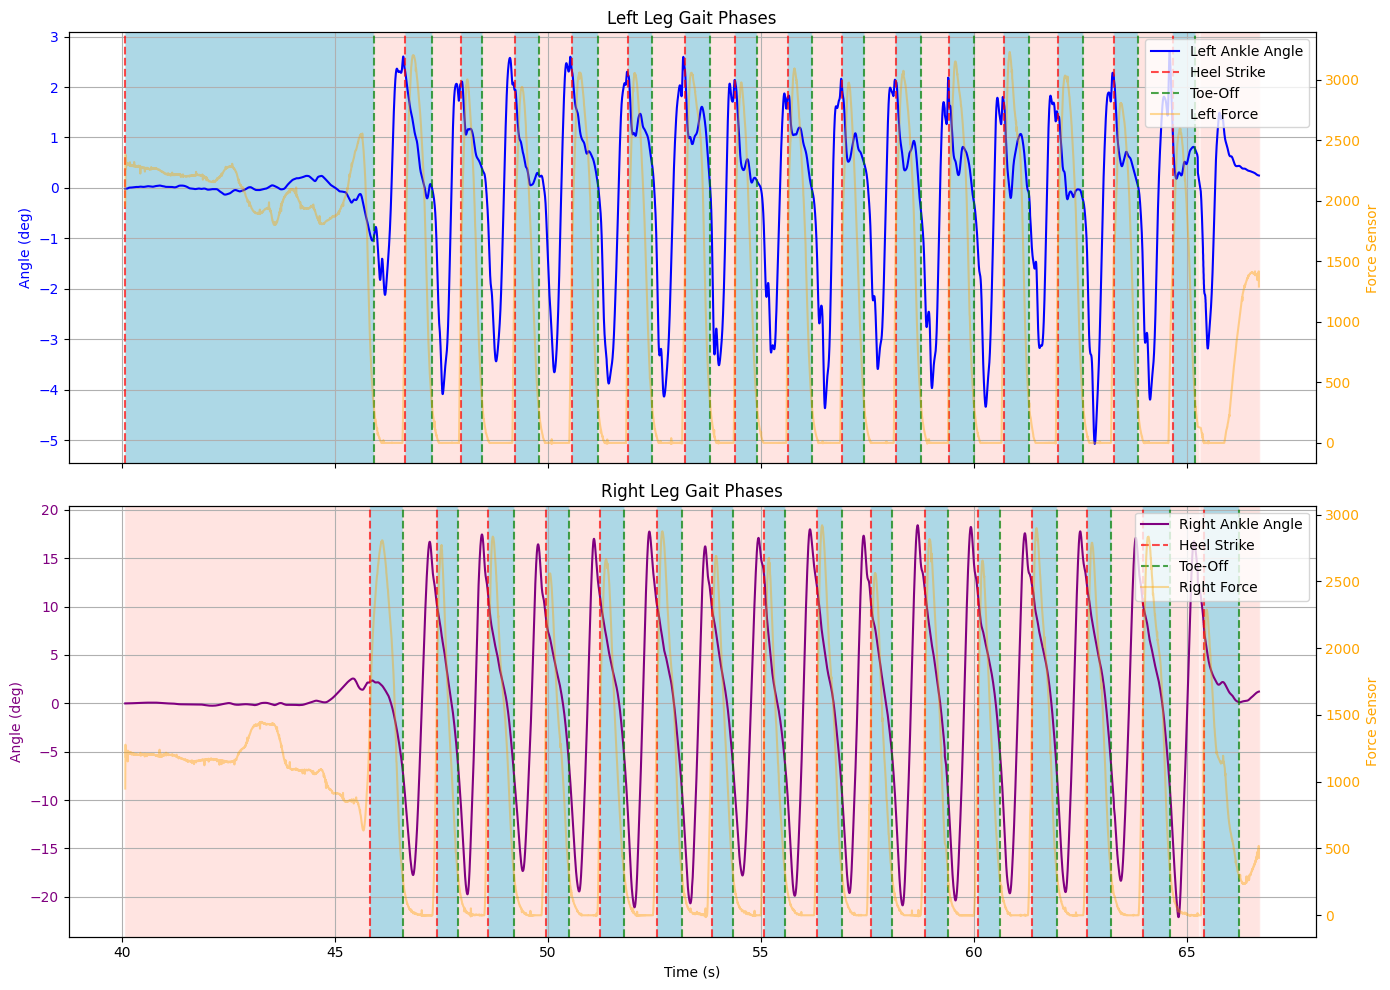

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# === LEFT LEG ===
ax1 = axs[0]
ax2 = ax1.twinx()

# Fill stance/swing background
for i in range(1, len(time)):
    if left_gait_phase[i] == "Stance":
        ax1.axvspan(time[i - 1], time[i], color='lightblue', alpha=0.3)
    elif left_gait_phase[i] == "Swing":
        ax1.axvspan(time[i - 1], time[i], color='mistyrose', alpha=0.3)


# Plot angle
ax1.plot(time, left_ankle_angle, label="Left Ankle Angle", color='blue')
ax1.set_ylabel("Angle (deg)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Left Leg Gait Phases")

# Plot force
ax2.plot(time, left_force, label="Left Force", color='orange', alpha=0.4)
ax2.set_ylabel("Force Sensor", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Events
for i, hs in enumerate(heel_strikes_ankle):
    ax1.axvline(hs, color='red', linestyle='--', alpha=0.7, label='Heel Strike' if i == 0 else "")
for i, to in enumerate(toe_offs_ankle):
    ax1.axvline(to, color='green', linestyle='--', alpha=0.7, label='Toe-Off' if i == 0 else "")

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
ax1.grid()

# === RIGHT LEG ===
ax3 = axs[1]
ax4 = ax3.twinx()

# Fill stance/swing background
for i in range(1, len(time_r)):
    if right_gait_phase[i] == "Stance":
        ax3.axvspan(time_r[i - 1], time_r[i], color='lightblue', alpha=0.3)
    elif right_gait_phase[i] == "Swing":
        ax3.axvspan(time_r[i - 1], time_r[i], color='mistyrose', alpha=0.3)


# Plot angle
ax3.plot(time_r, right_ankle_angle, label="Right Ankle Angle", color='purple')
ax3.set_ylabel("Angle (deg)", color='purple')
ax3.tick_params(axis='y', labelcolor='purple')
ax3.set_xlabel("Time (s)")
ax3.set_title("Right Leg Gait Phases")

# Plot force
ax4.plot(time_r, right_force, label="Right Force", color='orange', alpha=0.4)
ax4.set_ylabel("Force Sensor", color='orange')
ax4.tick_params(axis='y', labelcolor='orange')

# Events
for i, hs in enumerate(right_heel_strikes):
    ax3.axvline(hs, color='red', linestyle='--', alpha=0.7, label='Heel Strike' if i == 0 else "")
for i, to in enumerate(right_toe_offs):
    ax3.axvline(to, color='green', linestyle='--', alpha=0.7, label='Toe-Off' if i == 0 else "")

# Legends
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, loc="upper right")
ax3.grid()

plt.tight_layout()
plt.show()


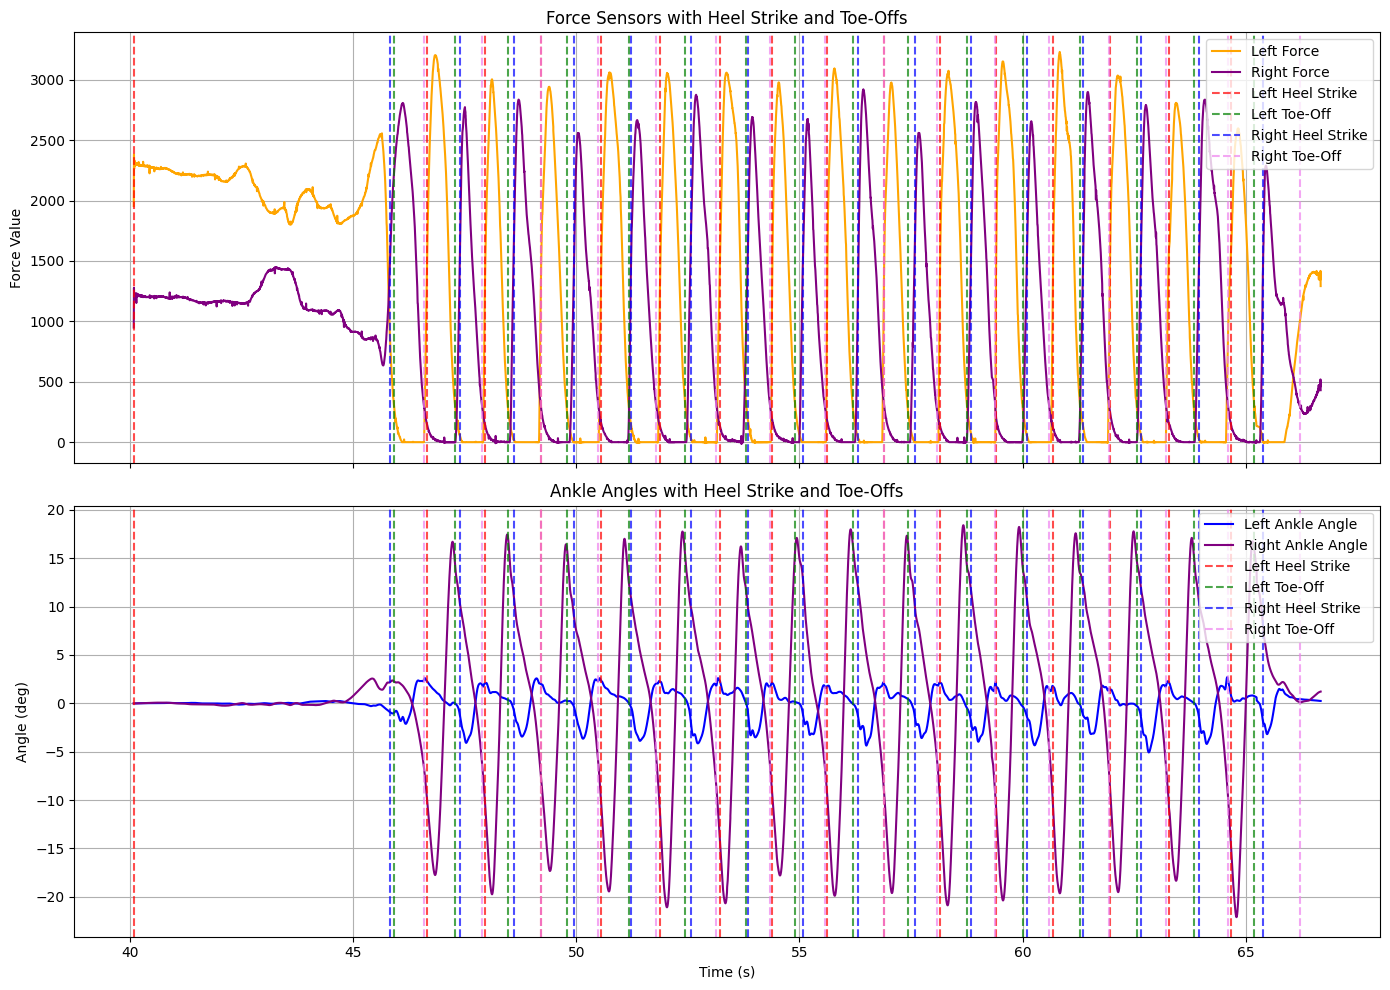

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# === PLOT 1: FORCE SENSORS + EVENTS ===
axs[0].plot(time, left_force, label="Left Force", color='orange')
axs[0].plot(time_r, right_force, label="Right Force", color='purple')

# Left Leg Events
for i, hs in enumerate(heel_strikes_ankle):
    axs[0].axvline(hs, color='red', linestyle='--', alpha=0.7, label='Left Heel Strike' if i == 0 else "")
for i, to in enumerate(toe_offs_ankle):
    axs[0].axvline(to, color='green', linestyle='--', alpha=0.7, label='Left Toe-Off' if i == 0 else "")

# Right Leg Events
for i, hs in enumerate(right_heel_strikes):
    axs[0].axvline(hs, color='blue', linestyle='--', alpha=0.7, label='Right Heel Strike' if i == 0 else "")
for i, to in enumerate(right_toe_offs):
    axs[0].axvline(to, color='violet', linestyle='--', alpha=0.7, label='Right Toe-Off' if i == 0 else "")

axs[0].set_title("Force Sensors with Heel Strike and Toe-Offs")
axs[0].set_ylabel("Force Value")
axs[0].legend(loc="upper right")
axs[0].grid()

# === PLOT 2: ANKLE ANGLES + EVENTS ===
axs[1].plot(time, left_ankle_angle, label="Left Ankle Angle", color='blue')
axs[1].plot(time_r, right_ankle_angle, label="Right Ankle Angle", color='purple')

# Left Leg Events
for i, hs in enumerate(heel_strikes_ankle):
    axs[1].axvline(hs, color='red', linestyle='--', alpha=0.7, label='Left Heel Strike' if i == 0 else "")
for i, to in enumerate(toe_offs_ankle):
    axs[1].axvline(to, color='green', linestyle='--', alpha=0.7, label='Left Toe-Off' if i == 0 else "")

# Right Leg Events
for i, hs in enumerate(right_heel_strikes):
    axs[1].axvline(hs, color='blue', linestyle='--', alpha=0.7, label='Right Heel Strike' if i == 0 else "")
for i, to in enumerate(right_toe_offs):
    axs[1].axvline(to, color='violet', linestyle='--', alpha=0.7, label='Right Toe-Off' if i == 0 else "")

axs[1].set_title("Ankle Angles with Heel Strike and Toe-Offs")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Angle (deg)")
axs[1].legend(loc="upper right")
axs[1].grid()

plt.tight_layout()
plt.show()


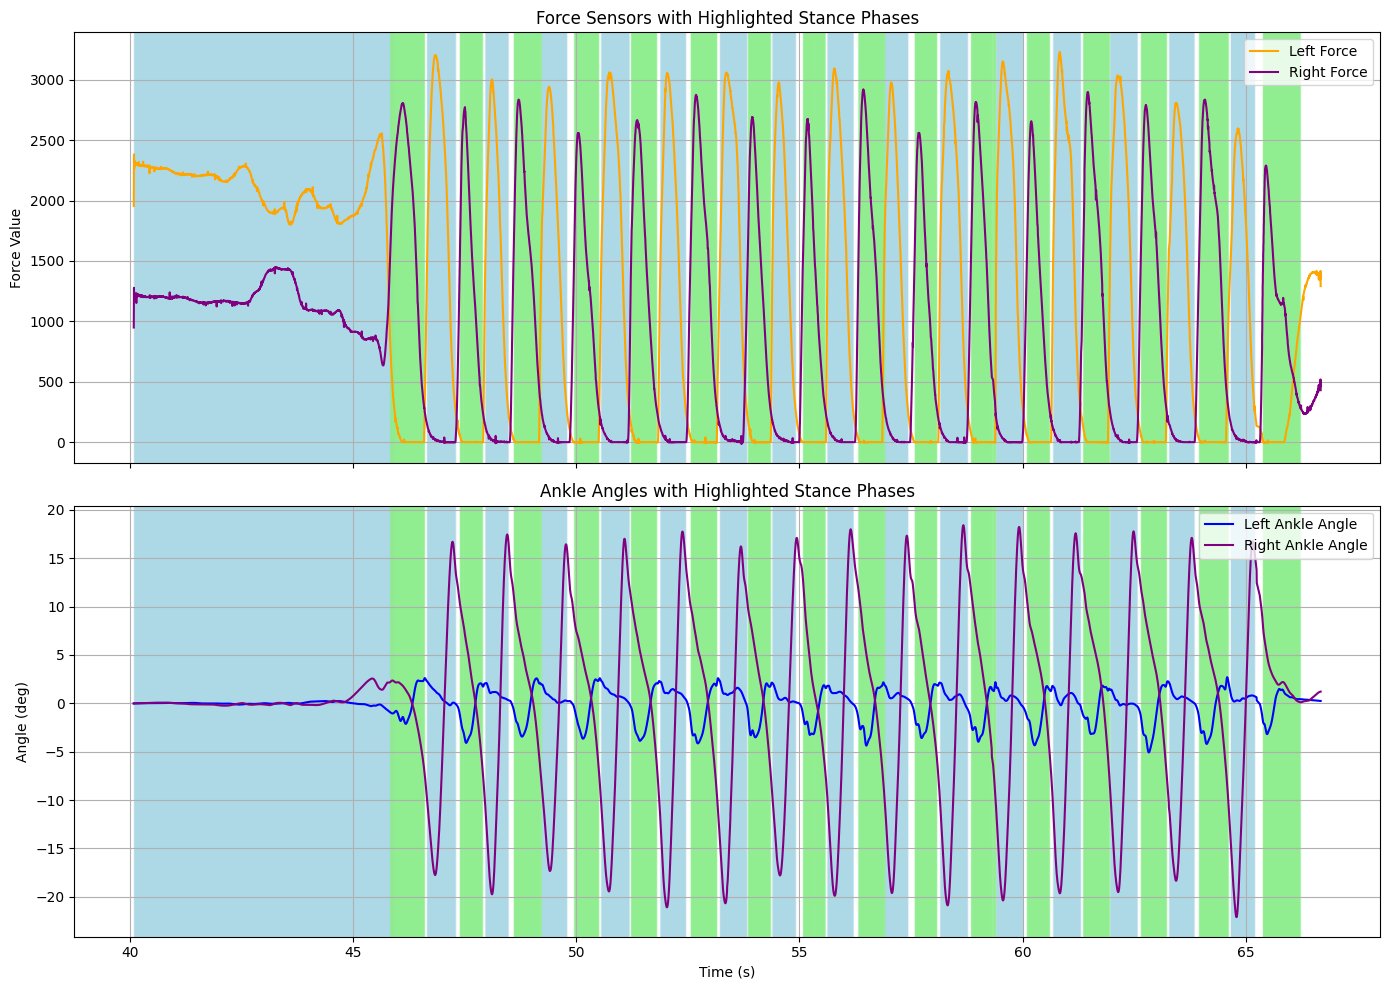

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# === PLOT 1: FORCE SENSORS with STANCE PHASES ===
axs[0].plot(time, left_force, label="Left Force", color='orange')
axs[0].plot(time_r, right_force, label="Right Force", color='purple')

# Highlight LEFT Stance (lightblue)
for i in range(1, len(left_gait_phase)):
    if left_gait_phase[i] == "Stance":
        axs[0].axvspan(time[i - 1], time[i], color='lightblue', alpha=0.3)

# Highlight RIGHT Stance (lightgreen)
for i in range(1, len(right_gait_phase)):
    if right_gait_phase[i] == "Stance":
        axs[0].axvspan(time_r[i - 1], time_r[i], color='lightgreen', alpha=0.3)

axs[0].set_title("Force Sensors with Highlighted Stance Phases")
axs[0].set_ylabel("Force Value")
axs[0].legend(loc="upper right")
axs[0].grid()

# === PLOT 2: ANKLE ANGLES with STANCE PHASES ===
axs[1].plot(time, left_ankle_angle, label="Left Ankle Angle", color='blue')
axs[1].plot(time_r, right_ankle_angle, label="Right Ankle Angle", color='purple')

# Highlight LEFT Stance
for i in range(1, len(left_gait_phase)):
    if left_gait_phase[i] == "Stance":
        axs[1].axvspan(time[i - 1], time[i], color='lightblue', alpha=0.3)

# Highlight RIGHT Stance
for i in range(1, len(right_gait_phase)):
    if right_gait_phase[i] == "Stance":
        axs[1].axvspan(time_r[i - 1], time_r[i], color='lightgreen', alpha=0.3)

axs[1].set_title("Ankle Angles with Highlighted Stance Phases")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Angle (deg)")
axs[1].legend(loc="upper right")
axs[1].grid()

plt.tight_layout()
plt.show()


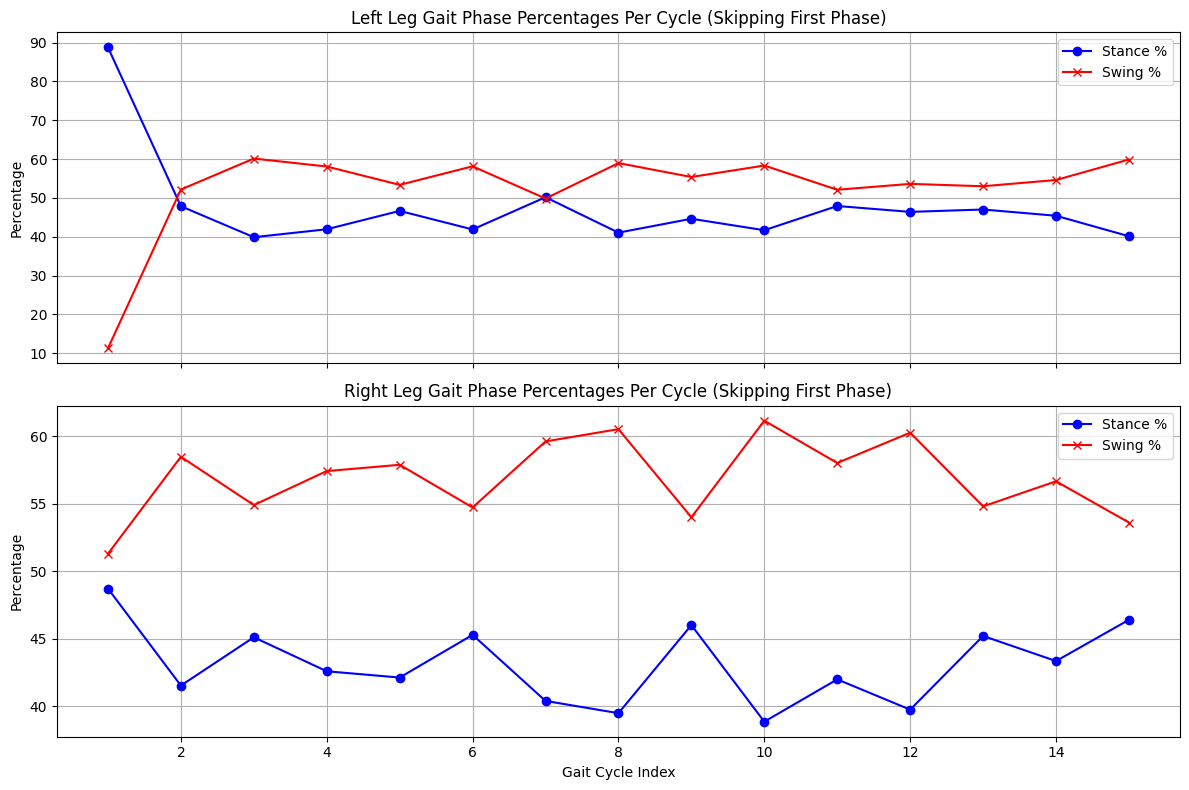

Left Leg Avg Stance: 47.42%, Swing: 52.58%
Right Leg Avg Stance: 43.12%, Swing: 56.88%


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def compute_phase_percentages_skip_first_phase(time, gait_phase, heel_strikes):
    gait_phase = np.array(gait_phase)
    heel_strikes = np.array(heel_strikes)

    stance_percentages = []
    swing_percentages = []
    cycles = []

    for i in range(len(heel_strikes) - 1):  # include all cycles
        start_time = heel_strikes[i]
        end_time = heel_strikes[i + 1]

        indices = np.where((time >= start_time) & (time < end_time))[0]
        if len(indices) == 0:
            continue
    
        # # Skip initial phase
        # first_phase = gait_phase[indices[0]]
                
        # # Find where the first different phase starts
        # for skip_index in indices:
        #     if gait_phase[skip_index] != first_phase:
        #         break
        # else:
        #     continue  # if all are same phase, skip this cycle

        # indices = indices[indices >= skip_index]  # remove initial phase segment

        # if len(indices) == 0:
        #     continue

        # Now calculate stance/swing percentages
        phases_in_cycle = gait_phase[indices]
        stance_count = np.sum(phases_in_cycle == "Stance")
        swing_count = np.sum(phases_in_cycle == "Swing")
        # print(f"Cycle {i + 1}: Stance Count: {stance_count}, Swing Count: {swing_count}")
        total = stance_count + swing_count

        if total == 0:
            continue
        
        # print(f"Cycle {i+1}: First skipped phase = {first_phase}")
        # print(f"  Phase counts: {np.unique(gait_phase[indices], return_counts=True)}")


        stance_pct = stance_count / total * 100
        swing_pct = swing_count / total * 100

        stance_percentages.append(stance_pct)
        swing_percentages.append(swing_pct)
        cycles.append(i + 1)  # 1-based index for plotting

    return np.array(cycles), np.array(stance_percentages), np.array(swing_percentages)

# --- Compute per-cycle gait phase percentages ---

left_cycles, left_stance_pct, left_swing_pct = compute_phase_percentages_skip_first_phase(
    time, left_gait_phase, heel_strikes_ankle
)

right_cycles, right_stance_pct, right_swing_pct = compute_phase_percentages_skip_first_phase(
    time_r, right_gait_phase, right_heel_strikes
)

# print(np.unique(right_gait_phase, return_counts=True))
# print(np.unique(left_gait_phase, return_counts=True))

# --- Plot per-cycle stance/swing percentages ---

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# LEFT LEG
axs[0].plot(left_cycles, left_stance_pct, label="Stance %", marker='o', color='blue')
axs[0].plot(left_cycles, left_swing_pct, label="Swing %", marker='x', color='red')
axs[0].set_title("Left Leg Gait Phase Percentages Per Cycle (Skipping First Phase)")
axs[0].set_ylabel("Percentage")
axs[0].legend()
axs[0].grid()

# RIGHT LEG
axs[1].plot(right_cycles, right_stance_pct, label="Stance %", marker='o', color='blue')
axs[1].plot(right_cycles, right_swing_pct, label="Swing %", marker='x', color='red')
axs[1].set_title("Right Leg Gait Phase Percentages Per Cycle (Skipping First Phase)")
axs[1].set_xlabel("Gait Cycle Index")
axs[1].set_ylabel("Percentage")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

# --- Optional: Mean % over cycles ---
print(f"Left Leg Avg Stance: {left_stance_pct.mean():.2f}%, Swing: {left_swing_pct.mean():.2f}%")
print(f"Right Leg Avg Stance: {right_stance_pct.mean():.2f}%, Swing: {right_swing_pct.mean():.2f}%")


In [13]:
print(f"Left Leg Stance: {left_stance_pct}, Swing: {left_swing_pct}")
print(f"Right Leg Stance: {right_stance_pct}, Swing: {right_swing_pct}")

Left Leg Stance: [88.77364246 47.85276074 39.87138264 41.91616766 46.64634146 41.86746988
 50.17182131 41.04234528 44.62025316 41.66666667 47.90996785 46.39498433
 47.00315457 45.39877301 40.11627907], Swing: [11.22635754 52.14723926 60.12861736 58.08383234 53.35365854 58.13253012
 49.82817869 58.95765472 55.37974684 58.33333333 52.09003215 53.60501567
 52.99684543 54.60122699 59.88372093]
Right Leg Stance: [48.71134021 41.5282392  45.10385757 42.58675079 42.12121212 45.28301887
 40.39087948 39.48220065 46.00638978 38.85350318 41.98717949 39.74358974
 45.20123839 43.34365325 46.39769452], Swing: [51.28865979 58.4717608  54.89614243 57.41324921 57.87878788 54.71698113
 59.60912052 60.51779935 53.99361022 61.14649682 58.01282051 60.25641026
 54.79876161 56.65634675 53.60230548]


In [ ]:
import numpy as np
import pandas as pd

def compute_summary_stats_exclude_first_cycle(
    left_cycles, left_stance_pct, left_swing_pct,
    right_cycles, right_stance_pct, right_swing_pct,
    left_heel_strikes, right_heel_strikes,
    left_toe_offs, right_toe_offs
):
    # Drop first cycle
    left_cycles = left_cycles[1:]
    right_cycles = right_cycles[1:]
    left_stance_pct = left_stance_pct[1:]
    left_swing_pct = left_swing_pct[1:]
    right_stance_pct = right_stance_pct[1:]
    right_swing_pct = right_swing_pct[1:]

    # Drop first heel strike to remove first step timing
    left_step_times = np.diff(left_heel_strikes)[1:]
    right_step_times = np.diff(right_heel_strikes)[1:]

    min_len = min(len(left_step_times), len(right_step_times))
    stride_symmetry_index = 100 * np.abs(left_step_times[:min_len] - right_step_times[:min_len]) / \
        ((left_step_times[:min_len] + right_step_times[:min_len]) / 2)

    # Cadence (steps per minute)
    total_time = max(left_heel_strikes[-1], right_heel_strikes[-1]) - min(left_heel_strikes[1], right_heel_strikes[1])
    cadence = (len(left_heel_strikes) + len(right_heel_strikes) - 2) / (total_time / 60)

    left_variability = {
        "stance_std": np.std(left_stance_pct),
        "swing_std": np.std(left_swing_pct)
    }
    right_variability = {
        "stance_std": np.std(right_stance_pct),
        "swing_std": np.std(right_swing_pct)
    }

    summary = {
        "Number of Left Cycles": len(left_cycles),
        "Number of Right Cycles": len(right_cycles),
        "Cadence (steps/min)": round(cadence, 2),
        "Number of Left Heel Strikes": len(left_heel_strikes),
        "Number of Right Heel Strikes": len(right_heel_strikes),
        "Number of Left Toe Offs": len(left_toe_offs),
        "Number of Right Toe Offs": len(right_toe_offs),
        "Left Avg Stance %": round(left_stance_pct.mean(), 2),
        "Left Avg Swing %": round(left_swing_pct.mean(), 2),
        "Right Avg Stance %": round(right_stance_pct.mean(), 2),
        "Right Avg Swing %": round(right_swing_pct.mean(), 2),
        "Left Stance Variability": round(left_variability['stance_std'], 2),
        "Left Swing Variability": round(left_variability['swing_std'], 2),
        "Right Stance Variability": round(right_variability['stance_std'], 2),
        "Right Swing Variability": round(right_variability['swing_std'], 2),
        "Avg Stride Symmetry Index %": round(stride_symmetry_index.mean(), 2)
    }

    table = pd.DataFrame({
        "Cycle Index": np.arange(2, 2 + min_len),  # Start from cycle 2
        "Left Step Time (s)": left_step_times[:min_len],
        "Right Step Time (s)": right_step_times[:min_len],
        "Stride Symmetry Index (%)": stride_symmetry_index
    })

    return summary, table


In [ ]:
summary, table = compute_summary_stats_exclude_first_cycle(
    left_cycles, left_stance_pct, left_swing_pct,
    right_cycles, right_stance_pct, right_swing_pct,
    heel_strikes, right_heel_strikes,
    toe_offs, right_toe_offs
)

print("\n===== Gait Summary =====")
for k, v in summary.items():
    print(f"{k}: {v}")

print("\n===== Step Timing and Symmetry Table =====")
print(table.to_string(index=False))



===== Gait Summary =====
Number of Left Cycles: 14
Number of Right Cycles: 14
Cadence (steps/min): 75.87
Number of Left Heel Strikes: 16
Number of Right Heel Strikes: 16
Number of Left Toe Offs: 16
Number of Right Toe Offs: 16
Left Avg Stance %: 44.46
Left Avg Swing %: 55.54
Right Avg Stance %: 42.72
Right Avg Swing %: 57.28
Left Stance Variability: 3.21
Left Swing Variability: 3.21
Right Stance Variability: 2.47
Right Swing Variability: 2.47
Avg Stride Symmetry Index %: 10.84

===== Step Timing and Symmetry Table =====
 Cycle Index  Left Step Time (s)  Right Step Time (s)  Stride Symmetry Index (%)
           1               6.569                1.560                 123.237791
           2               1.308                1.208                   7.949126
           3               1.252                1.356                   7.975460
           4               1.344                1.276                   5.190840
           5               1.324                1.332               